In [1]:
import sys; sys.path.append('../3rdparty/ElasticRods/python')

import elastic_rods, elastic_knots
from linkage_vis import LinkageViewer as Viewer
import numpy as np, matplotlib.pyplot as plt, matplotlib, os, json

from helpers import *

%load_ext autoreload
%autoreload 2

In [2]:
# Download the sample dataset (equilibrium states of knots with up to 9 crossings)
# The same data can also be downloaded manually from 
# https://drive.google.com/file/d/1mwGCbWD8-Ftku5eLRwOAuvM-NGCqdXfg/
root_dir = '../data/'
data_dir = 'L400-r0.2-UpTo9Crossings'

zip_file = data_dir + '.zip'
download_data(
    gdrive_id='1mwGCbWD8-Ftku5eLRwOAuvM-NGCqdXfg',
    output_dir=root_dir,
    zip_file=zip_file
)

Directory ../data/L400-r0.2-UpTo9Crossings already exists


# Analysis of the simulation results

In [3]:
# Load the KnotInfo knot table (see https://knotinfo.math.indiana.edu for more details)
knot_data = load_knot_table()
knot_data.head(3)

,Name,Alternating,DT Name,DT Rank,DT Notation,Conway Notation,Gauss Notation,PD Notation,Crossing Number,Unknotting Number,Bridge Index,Braid Index,Braid Length,Braid Notation,Symmetry Type,Full Symmetry Group,Montesinos Notation
0,0_1,Y,?,?,?,?,?,?,0,0,1,1,0.0,"[1, -1, 1]",?,?,?
1,3_1,Y,3a_1,2,[4; 6; 2],[3],{1; -2; 3; -1; 2; -3},[[1;5;2;4];[3;1;4;6];[5;3;6;2]],3,1,2,2,3.0,"[1, 1, 1]",reversible,Z2,K(1/3)
2,4_1,Y,4a_1,3,[4; 6; 8; 2],[22],{-1; 2; -3; 1; -4; 3; -2; 4},[[4;2;5;1];[8;6;1;5];[6;3;7;4];[2;7;3;8]],4,1,2,3,4.0,"[1, -2, 1, -2]",fully amphicheiral,D4,K(2/5)


In [4]:
# Load the attributes of the computed equilibrium states
import pandas as pd

eq_data = pd.DataFrame(columns=[
    'knot_type',
    'eq_id',
    'energy',
    'energy_bend',
    'energy_twist',
    'energy_stretch',
    'max_bend_stress',
    'total_curvature',
    'threedim',
    'spher_dev',
    'diameter',
    'writhe',
    'twist',
    'length_pc0',
    'length_pc1',
    'length_pc2',
    'lambda_7',
    'c_hull_area',
    'c_hull_volume',
])

data_path = root_dir + '{}/'.format(data_dir)
knot_types = [kt for kt in sorted_nicely(os.listdir(data_path)) if not kt == 'README.md']
for kt in knot_types:
    stats_path = data_path + '{}/'.format(kt) + 'stats.json'
    
    eq_data_curr_knot = pd.read_json(stats_path, dtype='float')
    eq_data_curr_knot.insert(0, 'eq_id', np.arange(eq_data_curr_knot.shape[0]))  # serial corrseponding to the .obj file
    eq_data_curr_knot.insert(0, 'knot_type', kt)
    
    eq_data = pd.concat([eq_data, eq_data_curr_knot], ignore_index=True)
    
eq_data[eq_data.columns[1:]] = eq_data[eq_data.columns[1:]].apply(pd.to_numeric)  # cast values to float
print("Attributes of {} equilibrium states have been loaded".format(eq_data.shape[0]))

Attributes of 5330 equilibrium states have been loaded


In [5]:
eq_data.head(3)

,knot_type,eq_id,energy,energy_bend,energy_twist,energy_stretch,max_bend_stress,total_curvature,threedim,spher_dev,diameter,writhe,twist,length_pc0,length_pc1,length_pc2,lambda_7,c_hull_area,c_hull_volume
0,0_1,0,0.124029,0.124029,5.733625e-28,8.259586e-23,6.280820,6.283185,3.028435e-11,3.824154e-10,127.325263,1.535130e-07,1.357037e-14,45.072655,45.072655,1.351202e-09,0.000001,25464.267294,0.000024
1,0_1,1,0.124029,0.124029,1.957656e-28,5.954214e-22,6.253505,6.283185,2.440754e-11,1.477700e-10,127.325263,8.654888e-08,2.798888e-14,45.072655,45.072655,1.088346e-09,0.000001,25464.267294,0.000020
2,0_1,2,0.124029,0.124029,1.788163e-25,9.567156e-18,6.209993,6.283185,7.876788e-10,9.497054e-09,127.325264,3.652173e-07,6.383727e-13,45.072655,45.072655,3.436519e-08,0.000001,25464.267294,0.000619


In [6]:
eq_data.tail(3)

,knot_type,eq_id,energy,energy_bend,energy_twist,energy_stretch,max_bend_stress,total_curvature,threedim,spher_dev,diameter,writhe,twist,length_pc0,length_pc1,length_pc2,lambda_7,c_hull_area,c_hull_volume
5327,9_49,47,1.345976,1.345973,8.907448e-27,0.000003,29.699478,19.530439,0.086921,8.753665,66.101872,-8.943803,4.693085e-14,18.586007,15.244512,1.351866,0.000005,5710.865092,7210.283576
5328,9_49,48,1.380350,1.380346,7.805172e-25,0.000004,31.571996,19.582957,0.090345,8.456011,64.913772,-8.046262,-1.034740e-13,18.711842,15.233386,1.333589,0.000004,5356.762762,6430.902998
5329,9_49,49,1.345953,1.345949,7.458992e-27,0.000003,29.614505,19.530052,0.086577,8.758969,65.933944,-8.944190,-1.048876e-13,18.585252,15.245926,1.343460,0.000005,5712.660762,7173.902378


### Filter and sort equilibria by attribute

In [7]:
def sort_knot_types_by_attribute(df, attribute, minimum=True, n_max=9):
    "Get the equilibrium states with max/min value of the given attribute (select at most one state per knot type)."
    
    if minimum:
        return df.loc[df.groupby('knot_type')[attribute].idxmin()].sort_values(by=attribute, ascending=minimum).iloc[0:n_max]
    else:
        return df.loc[df.groupby('knot_type')[attribute].idxmax()].sort_values(by=attribute, ascending=minimum).iloc[0:n_max]

In [8]:
rod_radius = 0.2
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])

In [9]:
# Equilibria with the lowest energy
df = sort_knot_types_by_attribute(eq_data, 'energy', minimum=True)
rods = load_rods_from_dataframe(df, data_path=data_path, material=material)

view_energy = Viewer(rods, width=1024, height=640)
view_energy.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [10]:
# Equilibria with the largest three-dimensionality score
df = sort_knot_types_by_attribute(eq_data, 'threedim', minimum=False, n_max=1)
rods = load_rods_from_dataframe(df, data_path=data_path, material=material)

view_threedim_high = Viewer(rods, width=1024, height=640)
view_threedim_high.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [11]:
# Equilibria with the smallest three-dimensionality score
df = sort_knot_types_by_attribute(eq_data, 'threedim', minimum=True)
rods = load_rods_from_dataframe(df, data_path=data_path, material=material)

view_threedim_low = Viewer(rods, width=1024, height=640)
view_threedim_low.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

### Milnor's bound
Check that, for any non-trivial knot, 
$$
\int_0^L \kappa > 2 \pi \text{b},
$$

where $\kappa = \Vert \mathbf{x}'' \Vert$ is the local curvature of the centerline curve $\mathbf{x}$, and $\text{b}$ is the bridge index of the corresponding knot type (see [[Milnor 1950]](https://www.jstor.org/stable/1969467)).

In case the bridge index of the knot type coincides with its bridge index (BB knots, see [[Diao et al. 2021]](https://arxiv.org/abs/2108.11790)), the global energy minimizer is known to be a multi-covered circle.

In [12]:
# Fetch bridge and braid indices from the knot table and check if knot type is BB
eq_data_milnor = eq_data.merge(
    knot_data[['Name', 'Bridge Index', 'Braid Index']], 
    left_on='knot_type', right_on='Name'
).drop('Name', axis=1)
eq_data_milnor = eq_data_milnor.rename(columns={'Bridge Index': 'bridge_index','Braid Index': 'braid_index'})
eq_data_milnor['is_bb'] = (eq_data_milnor['bridge_index'] == eq_data_milnor['braid_index'])

# Compute the "Milnor's distance",
# i.e. the ratio between the integrated curvature 
# and 2pi times the bridge index: it should always be > 1
eq_data_milnor['milnor_dist'] = eq_data_milnor['total_curvature'] / (2*np.pi*eq_data_milnor['bridge_index'])

<ipython-input-13-d24e68a84b4b>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Blues')


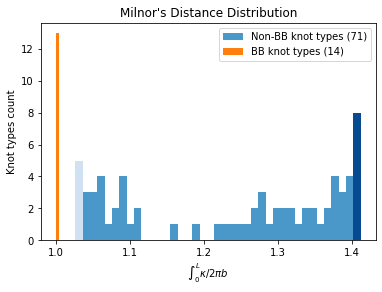

In [13]:
# For each knot type, selected the equilibrium state with the lowest total curvature
df_min_tot_curv = eq_data_milnor.loc[eq_data_milnor.groupby('knot_type').total_curvature.idxmin()]
md = df_min_tot_curv.milnor_dist.values
md_bb = df_min_tot_curv.milnor_dist[df_min_tot_curv.is_bb].values
md_not_bb = df_min_tot_curv.milnor_dist[~df_min_tot_curv.is_bb].values
n_bb = md_bb.size
n_not_bb = md_not_bb.size

# Plot histogram of Milnor's distances
fig, ax = plt.subplots()
cmap = matplotlib.cm.get_cmap('Blues')
blue_dark, blue, blue_light = cmap(0.9), cmap(0.6), cmap(0.2)

fig_dummy, ax_dummy = plt.subplots()
nbins = 40
hist_not_bb = ax_dummy.hist(md_not_bb, bins=np.linspace(np.min(md_not_bb), np.max(md_not_bb), nbins))
bins_hist_not_bb = hist_not_bb[1]
plt.close()

md_not_bb_bin1 = md_not_bb[md_not_bb <= bins_hist_not_bb[2]]
md_not_bb_bin2 = md_not_bb[md_not_bb > bins_hist_not_bb[-2]]
ax.hist(md_not_bb, bins=np.linspace(np.min(md_not_bb), np.max(md_not_bb), nbins), color=blue, label='Non-BB knot types ({})'.format(n_not_bb))
ax.hist(md_not_bb_bin2, bins=bins_hist_not_bb[-2:], color=blue_dark)
ax.hist(md_not_bb_bin1, bins=bins_hist_not_bb[0:2], color=blue_light)
ax.hist(md_bb, bins=[1, np.sort(md_bb)[-1]+1e-8, bins_hist_not_bb[0], bins_hist_not_bb[1]], color='C1', label='BB knot types ({})'.format(n_bb))
ax.legend()
ax.set_xlabel('$\int_0^L \kappa / 2 \pi b$')
ax.set_ylabel('Knot types count')
ax.set_title('Milnor\'s Distance Distribution')
plt.show()

In [14]:
# Select the knots to display from the dataset
df_bb = df_min_tot_curv[df_min_tot_curv.is_bb]
df_not_bb_1 = df_min_tot_curv[(~df_min_tot_curv.is_bb) & (df_min_tot_curv.milnor_dist < bins_hist_not_bb[ 1])].sort_values(by='milnor_dist')  # light blue
df_not_bb_2 = df_min_tot_curv[(~df_min_tot_curv.is_bb) & (df_min_tot_curv.milnor_dist > bins_hist_not_bb[-2])].sort_values(by='milnor_dist')  # dark blue

# Load the corresponding elastic rods
rod_radius = 0.2
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
rods_bb = load_rods_from_dataframe(df_bb, data_path=data_path, material=material)
rods_not_bb_1 = load_rods_from_dataframe(df_not_bb_1, data_path=data_path, material=material)
rods_not_bb_2 = load_rods_from_dataframe(df_not_bb_2, data_path=data_path, material=material)

In [15]:
# BB knots
print(df_bb[['knot_type', 'milnor_dist']].to_string(index=False))
view_bb = Viewer(rods_bb, width=1024, height=640)
view_bb.show()

knot_type  milnor_dist
      0_1     1.000000
      3_1     1.000028
      5_1     1.000324
      7_1     1.001361
     8_10     1.000663
     8_16     1.000560
     8_17     1.000499
     8_18     1.000168
     8_19     1.000041
     8_20     1.000100
     8_21     1.000293
      8_5     1.000683
      9_1     1.003854
     9_16     1.002413


Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [16]:
# Non-BB knots with the smallest Milnor's distance
print(df_not_bb_1[['knot_type', 'milnor_dist']].to_string(index=False))
view_not_bb_1 = Viewer(rods_not_bb_1, width=1024, height=640)
view_not_bb_1.show()

knot_type  milnor_dist
     9_46     1.026105
     9_35     1.026682
     9_42     1.031669
     9_49     1.033855
     8_15     1.034656


Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [17]:
# Non-BB knots with the largest Milnor's distance
print(df_not_bb_2[['knot_type', 'milnor_dist']].to_string(index=False))
view_not_bb_2 = Viewer(rods_not_bb_2, width=1024, height=640)
view_not_bb_2.show()

knot_type  milnor_dist
     9_27     1.403487
     9_18     1.403995
      9_7     1.405245
     9_31     1.405671
     9_19     1.409805
      9_8     1.411051
     9_15     1.411591
     9_23     1.412050


Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …